# Libraries import

In [0]:
#!pip install catboost

In [0]:
import networkx as nx

In [9]:
from tqdm.notebook import tqdm
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostClassifier
from sklearn.neighbors import NearestNeighbors
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#import lightgbm as lgb
from sklearn import metrics
from sklearn.model_selection import train_test_split
#from google.colab import drive

#drive.mount('/content/drive')

In [0]:
#pip install stellargraph[demos]

In [0]:
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import FullBatchLinkGenerator
from stellargraph.layer import GCN, LinkEmbedding
from tensorflow import keras
from sklearn import preprocessing, feature_extraction, model_selection
from stellargraph import globalvar
from stellargraph import datasets
from IPython.display import display, HTML
#%matplotlib inline

# Data import

In [2]:
edges = pd.read_csv('/Private/DataScience/Python/Fintech Hackaton Tochka/edges.csv')
ids = pd.read_csv('/Private/DataScience/Python/Fintech Hackaton Tochka/ids.csv')
vertices = pd.read_csv('/Private/DataScience/Python/Fintech Hackaton Tochka/vertices_normalized with neighbours reworked.csv')

In [3]:
vertices['main_okved'] = vertices['main_okved'].astype(str)
vertices['company_type'] = vertices['company_type'].astype(str)

In [4]:
le = LabelEncoder()
vertices['main_okved'] = le.fit_transform(vertices['main_okved'])
vertices['company_type'] = le.fit_transform(vertices['company_type'])

# NetworkX graph

In [0]:
edges.drop(["value","n_transactions"], axis=1, inplace=True)
edges.columns = ["source","target"]

In [0]:
vertices.set_index('id', inplace=True)

In [0]:
g = nx.from_pandas_edgelist(edges) 

In [0]:
g.add_nodes_from(vertices.index)

In [0]:
degree_dict = dict(g.degree(g.nodes()))
nx.set_node_attributes(g, degree_dict, 'degree')
#nx.set_node_attributes(g, vertices.to_dict('index'))

In [13]:
g.nodes[1]

{'degree': 2}

# Stellargraph graph

In [0]:
from stellargraph import StellarGraph

In [0]:
#G = StellarGraph(vertices, edges)

In [0]:
G = StellarGraph.from_networkx(g, node_features=vertices,node_type_default='company', edge_type_default='transaction')

In [0]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 1534749, Edges: 4685644

 Node types:
  company: [1534749]
    Features: float32 vector, length 3
    Edge types: company-transaction->company

 Edge types:
    company-transaction->company: [4685644]
        Weights: all 1 (default)


Must be **equal**

In [0]:
len(vertices)

1534749

In [0]:
g.clear()

Splitting for model

In [0]:
%time G_train, edge_ids_train, edge_labels_train = EdgeSplitter(G).train_test_split(p=0.01, method="global", keep_connected=True)

Removed 1000 edges
Removed 2000 edges
Removed 3000 edges
Removed 4000 edges
Removed 5000 edges
Removed 6000 edges
Removed 7000 edges
Removed 8000 edges
Removed 9000 edges
Removed 10000 edges
Removed 11000 edges
Removed 12000 edges
Removed 13000 edges
Removed 14000 edges
Removed 15000 edges
Removed 16000 edges
Removed 17000 edges
Removed 18000 edges
Removed 19000 edges
Removed 20000 edges
Removed 21000 edges
Removed 22000 edges
Removed 23000 edges
Removed 24000 edges
Removed 25000 edges
Removed 26000 edges
Removed 27000 edges
Removed 28000 edges
Removed 29000 edges
Removed 30000 edges
Removed 31000 edges
Removed 32000 edges
Removed 33000 edges
Removed 34000 edges
Removed 35000 edges
Removed 36000 edges
Removed 37000 edges
Removed 38000 edges
Removed 39000 edges
Removed 40000 edges
Removed 41000 edges
Removed 42000 edges
Removed 43000 edges
Removed 44000 edges
Removed 45000 edges
Removed 46000 edges
Sampled 1000 negative examples
Sampled 2000 negative examples
Sampled 3000 negative examp

In [0]:
train_gen = FullBatchLinkGenerator(G, method="gcn")
train_flow = train_gen.flow(edge_ids_train, edge_labels_train)

Using GCN (local pooling) filters...


In [0]:
gcn = GCN(layer_sizes=[16, 16], activations=["relu", "relu"], generator=train_gen, dropout=0.3)

In [0]:
x_inp, x_out = gcn.in_out_tensors()
prediction = LinkEmbedding(activation="relu", method="ip")(x_out)
prediction = keras.layers.Reshape((-1,))(prediction)
model = keras.Model(inputs=x_inp, outputs=prediction)
model.compile(optimizer=keras.optimizers.Adam(lr=0.4),loss=keras.losses.binary_crossentropy,metrics=keras.metrics.binary_accuracy)

In [0]:
init_train_metrics = model.evaluate(train_flow)
#init_test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

#print("\nTest Set Metrics of the initial (untrained) model:")
#for name, val in zip(model.metrics_names, init_test_metrics):
#    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 2ms/step - loss: 7.6246 - binary_accuracy: 0.5000

Train Set Metrics of the initial (untrained) model:
	loss: 7.6246
	binary_accuracy: 0.5000


In [0]:
history = model.fit(train_flow, epochs=50,verbose=2, shuffle=False)

Epoch 1/50
1/1 - 0s - loss: 7.7124 - binary_accuracy: 0.5000
Epoch 2/50
1/1 - 0s - loss: 7.7124 - binary_accuracy: 0.5000
Epoch 3/50
1/1 - 0s - loss: 7.7124 - binary_accuracy: 0.5000
Epoch 4/50


KeyboardInterrupt: ignored

In [0]:
import stellargraph as sg

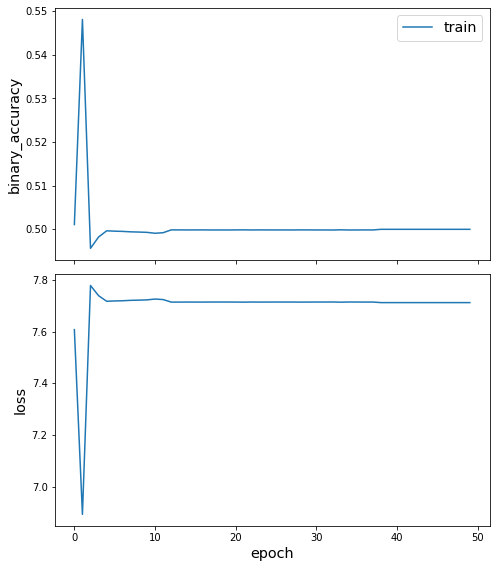

In [0]:
sg.utils.plot_history(history)

In [0]:
train_metrics = model.evaluate(train_flow)

print("\nTrain Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 1ms/step - loss: 7.6246 - binary_accuracy: 0.5000

Train Set Metrics of the trained model:
	loss: 7.6246
	binary_accuracy: 0.5000


# Attr2Vec

In [0]:
import stellargraph as sg
from stellargraph.data import UnsupervisedSampler
from stellargraph.mapper import Attri2VecLinkGenerator, Attri2VecNodeGenerator
from stellargraph.layer import Attri2Vec, link_classification

from tensorflow import keras

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

In [0]:
nodes = list(G_train.nodes())
number_of_walks = 2
length = 5

In [0]:
unsupervised_samples = UnsupervisedSampler(
    G_train, nodes=nodes, length=length, number_of_walks=number_of_walks
)

In [0]:
batch_size = 50
epochs = 6

In [0]:
generator = Attri2VecLinkGenerator(G_train, batch_size)

In [0]:
layer_sizes = [128]
attri2vec = Attri2Vec(
    layer_sizes=layer_sizes, generator=generator, bias=False, normalize=None
)

In [0]:
x_inp, x_out = attri2vec.in_out_tensors()

In [0]:
prediction = link_classification(
    output_dim=1, output_act="sigmoid", edge_embedding_method="ip"
)(x_out)

link_classification: using 'ip' method to combine node embeddings into edge embeddings


In [0]:
model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer=keras.optimizers.Adam(lr=1e-2),
    loss=keras.losses.binary_crossentropy,
    metrics=keras.metrics.binary_accuracy
)

In [0]:
dat = generator.flow(unsupervised_samples)

In [0]:
history = model.fit(dat,
    epochs=epochs,
    verbose=2,
    shuffle=True)

Epoch 1/6


# With neighbours

1) 90+% компаний-партнеров для искомой лежат через две транзакций. (Искомая - партнеры - партнеры партнеров - их партнеры)
Можно пытаться сократить таким образом датасет до размеров от 900т до 400т строк для компании.
2) Можно сгенерить 3 фичи из нашего файла edges для каждой отдельной компании:
сумма value, сумма n_transactions, а также число партнерств (count)Методом фильтраций (без ml) я надеялся взять больше чем pipeline, но уперся в 1400, и расстроился когда узнал что пайплайн может взять и 2т)

In [10]:
from tqdm.notebook import tqdm


In [11]:
from sklearn.preprocessing import StandardScaler

In [0]:
ss = StandardScaler()
vertices['company_type'] = ss.fit_transform(vertices['company_type'].values.reshape(-1, 1))
vertices['main_okved'] = ss.fit_transform(vertices['main_okved'].values.reshape(-1, 1))
vertices['region_code'] = ss.fit_transform(vertices['region_code'].values.reshape(-1, 1))

In [12]:
vertices.head()

,id,main_okved,region_code,company_type,degree,1_nearest_neigbour,2_nearest_neigbour,3_nearest_neigbour,4_nearest_neigbour
0,1,66,0.996493,3,-0.076670,1192393,289307,1124981,812393
1,2,162,1.041164,3,-0.076670,803412,1078506,1104251,761842
2,3,369,-0.209639,3,-0.094982,844033,785339,798433,371028
3,4,128,1.353865,3,-0.040046,38264,3,634467,522982
4,5,746,-0.209639,3,-0.040046,854068,829228,1095112,276593


In [18]:
errors = []
degrees = []
for j in tqdm(vertices.index):
    try:
        degrees.append([j,g.nodes[j]['degree']])
    except:
    #print('Error',i)
        errors.append(j)
degree = pd.DataFrame(degrees, columns=['id','degree'])
degree.set_index('id', inplace=True)
vertices = vertices.merge(degree, how='inner', on='id')

In [6]:
vertices.head()

,id,main_okved,region_code,company_type,degree,1_nearest_neigbour,2_nearest_neigbour,3_nearest_neigbour,4_nearest_neigbour
0,1,66,0.996493,3,-0.076670,1192393,289307,1124981,812393
1,2,162,1.041164,3,-0.076670,803412,1078506,1104251,761842
2,3,369,-0.209639,3,-0.094982,844033,785339,798433,371028
3,4,128,1.353865,3,-0.040046,38264,3,634467,522982
4,5,746,-0.209639,3,-0.040046,854068,829228,1095112,276593


In [0]:
vertices['degree'] = ss.fit_transform(vertices['degree'].values.reshape(-1, 1))

In [21]:
len(vertices)

1534749

In [0]:
import numpy as np

In [23]:
%time nbrs=NearestNeighbors(n_neighbors=4, algorithm='kd_tree', n_jobs=-1).fit(np.array(vertices.values))

CPU times: user 5min 48s, sys: 598 ms, total: 5min 49s
Wall time: 5min 48s


In [0]:
distances, indices = nbrs.kneighbors(np.array(vertices.values))

In [0]:
vertices['1_nearest_neigbour'] = [indices[r][0] for r in range(len(vertices.index))]
vertices['2_nearest_neigbour'] = [indices[r][1] for r in range(len(vertices.index))]
vertices['3_nearest_neigbour'] = [indices[r][2] for r in range(len(vertices.index))]
vertices['4_nearest_neigbour'] = [indices[r][3] for r in range(len(vertices.index))]

In [7]:
vertices.head()

,id,main_okved,region_code,company_type,degree,1_nearest_neigbour,2_nearest_neigbour,3_nearest_neigbour,4_nearest_neigbour
0,1,66,0.996493,3,-0.076670,1192393,289307,1124981,812393
1,2,162,1.041164,3,-0.076670,803412,1078506,1104251,761842
2,3,369,-0.209639,3,-0.094982,844033,785339,798433,371028
3,4,128,1.353865,3,-0.040046,38264,3,634467,522982
4,5,746,-0.209639,3,-0.040046,854068,829228,1095112,276593


In [8]:
vertices['1_nn_1_nn'] = [indices[vertices['1_nearest_neigbour'].iloc[r]][0] for r in range(len(vertices.index))]
vertices['1_nn_2_nn'] = [indices[vertices['1_nearest_neigbour'].iloc[r]][1] for r in range(len(vertices.index))]
vertices['1_nn_3_nn'] = [indices[vertices['1_nearest_neigbour'].iloc[r]][2] for r in range(len(vertices.index))]
vertices['1_nn_4_nn'] = [indices[vertices['1_nearest_neigbour'].iloc[r]][3] for r in range(len(vertices.index))]

NameError: name 'indices' is not defined

In [53]:
vertices.head()

,main_okved,region_code,company_type,degree,1_nearest_neigbour,2_nearest_neigbour,3_nearest_neigbour,4_nearest_neigbour,1_nn_1_nn,1_nn_2_nn,1_nn_3_nn,1_nn_4_nn
id,,,,,,,,,,,,
1,-0.299857,0.987268,0.539115,-0.075680,557063,293141,578774,37782,557063,293141,578774,37782
2,-0.730534,1.031696,0.539115,-0.075680,143702,782284,569780,1122205,143702,782284,569780,1122205
3,-1.659182,-0.212291,0.539115,-0.094111,148023,867833,776689,808967,148023,867833,776689,808967
4,-0.578003,1.520405,0.539115,-0.038817,38788,642870,3,529935,38788,642870,3,529935
5,0.458315,-0.212291,0.539115,-0.038817,1109678,865350,116777,664853,1109678,865350,116777,664853


In [0]:
vertices['2_nn_1_nn'] = [indices[vertices['2_nearest_neigbour'].iloc[r]][0] for r in vertices.index-1]
vertices['2_nn_2_nn'] = [indices[vertices['2_nearest_neigbour'].iloc[r]][1] for r in vertices.index-1]
vertices['2_nn_3_nn'] = [indices[vertices['2_nearest_neigbour'].iloc[r]][2] for r in vertices.index-1]
vertices['2_nn_4_nn'] = [indices[vertices['2_nearest_neigbour'].iloc[r]][3] for r in vertices.index-1]
vertices['3_nn_1_nn'] = [indices[vertices['3_nearest_neigbour'].iloc[r]][0] for r in vertices.index-1]
vertices['3_nn_2_nn'] = [indices[vertices['3_nearest_neigbour'].iloc[r]][1] for r in vertices.index-1]
vertices['3_nn_3_nn'] = [indices[vertices['3_nearest_neigbour'].iloc[r]][2] for r in vertices.index-1]
vertices['3_nn_4_nn'] = [indices[vertices['3_nearest_neigbour'].iloc[r]][3] for r in vertices.index-1]
vertices['4_nn_1_nn'] = [indices[vertices['4_nearest_neigbour'].iloc[r]][0] for r in vertices.index-1]
vertices['4_nn_2_nn'] = [indices[vertices['4_nearest_neigbour'].iloc[r]][1] for r in vertices.index-1]
vertices['4_nn_3_nn'] = [indices[vertices['4_nearest_neigbour'].iloc[r]][2] for r in vertices.index-1]
vertices['4_nn_4_nn'] = [indices[vertices['4_nearest_neigbour'].iloc[r]][3] for r in vertices.index-1]

In [56]:
vertices.head()

,main_okved,region_code,company_type,degree,1_nearest_neigbour,2_nearest_neigbour,3_nearest_neigbour,4_nearest_neigbour,1_nn_1_nn,1_nn_2_nn,1_nn_3_nn,1_nn_4_nn,2_nn_1_nn,2_nn_2_nn,2_nn_3_nn,2_nn_4_nn,3_nn_1_nn,3_nn_2_nn,3_nn_3_nn,3_nn_4_nn,4_nn_1_nn,4_nn_2_nn,4_nn_3_nn,4_nn_4_nn
id,,,,,,,,,,,,,,,,,,,,,,,,
1,-0.299857,0.987268,0.539115,-0.075680,557063,293141,578774,37782,557063,293141,578774,37782,557063,293141,578774,37782,557063,293141,578774,37782,557063,293141,578774,37782
2,-0.730534,1.031696,0.539115,-0.075680,143702,782284,569780,1122205,143702,782284,569780,1122205,143702,782284,569780,1122205,143702,782284,569780,1122205,143702,782284,569780,1122205
3,-1.659182,-0.212291,0.539115,-0.094111,148023,867833,776689,808967,148023,867833,776689,808967,148023,867833,776689,808967,148023,867833,776689,808967,148023,867833,776689,808967
4,-0.578003,1.520405,0.539115,-0.038817,38788,642870,3,529935,38788,642870,3,529935,38788,642870,3,529935,38788,642870,3,529935,529935,1247537,271393,486771
5,0.458315,-0.212291,0.539115,-0.038817,1109678,865350,116777,664853,1109678,865350,116777,664853,1109678,865350,116777,664853,1109678,865350,116777,664853,1109678,865350,116777,664853


In [0]:
#vertices.to_csv("vertices wth neigh.csv")